In [1]:
#encoding=utf-8
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import time,datetime
from matplotlib import pyplot as plt
from tensorflow.contrib import rnn
import pickle

#配置matplotlib画图的符号
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示坐标中的负号


/home/work/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#———————————————————数据抽取—————————————————————
columns = ['biz_id', 'car_type', 'section', 'week_id', 'holiday_id', 'temperature', 'weather', 'target']
from hive_client import HiveClient
hive_client = HiveClient()
begin_date = '2019-08-24'
begin_date_unformatted = '20190824'
end_date = '2019-09-01'
end_date_unformatted = '20190901'


load_pickle = True
#天气
hsql='''
    select distinct city_id,temperature,weather_desc,report_time,
    from_unixtime(unix_timestamp(report_time,'yyyy-MM-dd HH:mm:ss')+1800,'yyyy-MM-dd HH:mm:ss') as report_end_time
    from daojia_ml.express_weather_info
    where report_time>='{0}' and report_time<'{1}'
'''.format(begin_date, end_date)
if(load_pickle == False):
    with open('data/weather', 'w+') as f:
        status, weather_res = hive_client.query(hsql)
        pickle.dump(weather_res, f)
else:
    with open('data/weather', 'r') as f:
        weather_res = pickle.load(f)
weather_df = pd.DataFrame(weather_res, columns=['city_id', 'temperature', 'weather', 'start', 'end'])

#日期
hsql='''
    select distinct to_date(service_time) as service_dt,
    service_time_week_id, service_time_holiday_id
    from daojia_ml.express_odp_order_info_test
    where dt>='{0}' and dt<'{1}'
'''.format(begin_date_unformatted, end_date_unformatted)
if(load_pickle == False):
    with open('data/date', 'w+') as f:
        status, date_res = hive_client.query(hsql)
        pickle.dump(date_res, f)
else:
    with open('data/date', 'r') as f:
        date_res = pickle.load(f)
date_df = pd.DataFrame(date_res, columns=['service_dt', 'week_id', 'holiday_id'])


#商圈
headers='''
ADD jar hdfs://nameservice1/bigdata_platform/hive_udf/business-all.jar;
CREATE temporary FUNCTION get_biz AS 'com.daojia.business.district.view.commons.validate.BusinessByGps';
'''
hsql='''
    select city_id,car_type,service_time,
    split(get_biz(start_gps,cast(city_id as int)),',')[2] as biz_id
    from sy_dw_f.f_agt_order_info
    where service_time>='{0}' and service_time<'{1}'
    and split(get_biz(start_gps,cast(city_id as int)),',')[2]!=''
    and need_last_order='Y' and state=7
'''.format(begin_date, end_date)
if(load_pickle == False):
    with open('data/biz', 'w+') as f:
        status, biz_res = hive_client.query(hsql, headers=headers)
        pickle.dump(biz_res, f)
else:
    with open('data/biz', 'r') as f:
        biz_res = pickle.load(f)
biz_df = pd.DataFrame(biz_res, columns=['city_id', 'car_type', 'service_time', 'biz_id'])

biz_df = biz_df[(biz_df.biz_id != '') & (biz_df.biz_id!='NULL')]
time_section = []
time_groupkey = []
for index,row in biz_df.iterrows():
    t_time = row['service_time'].split(':')[0]
    time_section.append(t_time)
    time_groupkey.append(row['biz_id']+','+row['car_type']+','+t_time)
biz_df['time_section'] = time_section
biz_df['time_groupkey'] = time_groupkey
time_count = biz_df.groupby(['time_groupkey'])['service_time'].size()


# 每小时一个分段
cur_time = datetime.datetime.strptime(biz_df['service_time'].min(), '%Y-%m-%d %H:%M:%S')
end_time = datetime.datetime.strptime(biz_df['service_time'].max(), '%Y-%m-%d %H:%M:%S')
index_uniq = biz_df.groupby(['city_id','biz_id','car_type'])['time_section'].apply(lambda x:len(x.unique()))
index_uniq = [idx for idx in index_uniq.index if index_uniq[idx]>=30]
vals = []
weather_info = {}
while cur_time < end_time:
    hour = cur_time.hour
    cur_time_date = cur_time.strftime('%Y-%m-%d')
    cur_time_str = cur_time.strftime('%Y-%m-%d %H')
    t_date = date_df[date_df.service_dt==cur_time_date]
    t_week = t_date['week_id'].values[0] if len(t_date) > 0 else np.nan
    t_holiday = t_date['holiday_id'].values[0] if len(t_date) > 0 else np.nan
    for idx in index_uniq:
        if cur_time_str not in weather_info:
            t_weather = weather_df[(weather_df.city_id==idx[0]) & (weather_df.end>cur_time_str)].sort_values(by=['start'])
            t_temperature = t_weather['temperature'].values[0] if len(t_weather)>0 else np.nan
            t_weather_val = t_weather['weather'].values[0] if len(t_weather)>0 else np.nan
            weather_info[cur_time_str] = (t_temperature, t_weather_val)
        t_temperature = weather_info[cur_time_str][0]
        t_weather_val = weather_info[cur_time_str][1]
        t_biz_key = idx[1] + ',' + idx[2] + ',' + cur_time_str
        t_cnt = time_count[t_biz_key] if t_biz_key in time_count.index else 0
        vals.append([idx[1], idx[2], cur_time_str, idx[0], t_week, t_holiday, hour, t_temperature, t_weather_val, t_cnt])
    cur_time+=datetime.timedelta(hours=1)

data = pd.DataFrame(vals, columns=['biz_id','car_type','time_section','city_id','week_id','holiday_id','hour','temperature','weather','cnt']).astype('float32', errors='ignore')
print len(data)
print data.head()

133632
           biz_id car_type   time_section city_id week_id holiday_id  hour  \
0    need_city1_1        0  2019-08-24 00       1       6          1   0.0   
1    need_city1_1        2  2019-08-24 00       1       6          1   0.0   
2  need_city1_100        0  2019-08-24 00       1       6          1   0.0   
3  need_city1_100       10  2019-08-24 00       1       6          1   0.0   
4  need_city1_104        0  2019-08-24 00       1       6          1   0.0   

  temperature weather  cnt  
0        24.0      多云  0.0  
1        24.0      多云  0.0  
2        24.0      多云  0.0  
3        24.0      多云  0.0  
4        24.0      多云  1.0  


In [3]:
#———————————————————特征处理—————————————————————
do_embedding = False
do_embedding_update = False
embedding_model_path = 'embedding_model/item2vec.model'
item_vector_path = 'embedding_model/item_vector'
onehot_feature_path = 'embedding_model/feature_dict'
item_vector_dimension = 30

if do_embedding:
    #index
    item_idx_dict = {}
    item_dict = {}
    item_cnt = 0
    item_col = []
    for idx,row in data.iterrows():
        key = str(row['car_type']) + ',' + str(row['city_id']) + ',' + str(row['week_id']) \
            + ',' + str(row['holiday_id']) + ',' + str(row['hour']) + ',' + str(row['weather']) + ',' + str(row['temperature'])
        if key not in item_dict:
            item_dict[key] = item_cnt
            item_idx_dict[str(item_cnt)] = key
            item_cnt += 1
        item_col.append(str(item_dict[key]))
    item_df = data.loc[:, ['biz_id', 'car_type', 'time_section', 'cnt']]
    item_df['item'] = item_col
    
#     #generate sentence by biz_id,car_type,time_section
#     item_list = []
#     item_groupby = item_df.groupby(['biz_id','car_type'])
#     for name,group in item_groupby:
#         t_data = group.sort_values(by=['time_section']).drop(['biz_id','car_type','time_section'], axis=1)
#         item_list.append(list(t_data['item'].values))
    
    #generate sentence by cnt
    item_list = []
    item_groupby = item_df.groupby(['cnt'])
    for name,group in item_groupby:
        item_list.append(list(group['item'].values))
    
    #embedding
    from gensim.models import word2vec
    if do_embedding_update:
        embedding_model = word2vec.Word2Vec.load(embedding_model_path)
        embedding_model.build_vocab(item_list, update=True) 
        embedding_model.train(item_list, total_examples=model.corpus_count, epochs=model.iter)
    else:
        embedding_model = word2vec.Word2Vec(item_list, size=item_vector_dimension, sg=1, hs = 0, window=1e8)
    embedding_model.save(embedding_model_path)
    
    from itertools import imap
    with open(item_vector_path, 'w+') as f:
        for item in embedding_model.wv.index2word:
            f.write('%s\t%s\n'%(item_idx_dict[item], ",".join(imap(str,embedding_model[item]))))
    
    #vector joint
    item_vec_cols = [[] for i in range(item_vector_dimension)]
    for idx,row in data.iterrows():
        key = str(row['car_type']) + ',' + str(row['city_id']) + ',' + str(row['week_id']) \
            + ',' + str(row['holiday_id']) + ',' + str(row['hour']) + ',' + str(row['weather']) + ',' + str(row['temperature'])
        item_id = str(item_dict[key])
        item_vec = np.zeros(item_vector_dimension)
        if item_id in embedding_model:
            item_vec = embedding_model[item_id]
        for i,t in enumerate(item_vec_cols):
            t.append(item_vec[i])
    for i in range(item_vector_dimension):
        data['embedding_'+str(i)] = item_vec_cols[i]
    data = data.drop(['city_id','week_id','holiday_id','hour','weather','temperature'], axis=1)
else:
    data = data.join(pd.get_dummies(data['car_type'], prefix='car_type', prefix_sep='-'))
    data = data.join(pd.get_dummies(data['city_id'], prefix='city_id', prefix_sep='-'))
    data = data.join(pd.get_dummies(data['week_id'], prefix='week_id', prefix_sep='-'))
    data = data.join(pd.get_dummies(data['holiday_id'], prefix='holiday_id', prefix_sep='-'))
    data = data.join(pd.get_dummies(data['hour'], prefix='hour', prefix_sep='-'))
    data = data.join(pd.get_dummies(data['weather'], prefix='weather', prefix_sep='-'))
    data = data.join(pd.get_dummies(data['temperature'], prefix='temperature', prefix_sep='-'))
    with open(onehot_feature_path, 'w+') as f:
        for i,col in enumerate([col for col in data.columns if col.find('-')>=0]):
            f.write("%s\t%d\n"%(col,i))
    data = data.drop(['city_id','week_id','holiday_id','hour','weather','temperature'], axis=1)
print data.head()

           biz_id car_type   time_section  cnt  car_type-0  car_type-1  \
0    need_city1_1        0  2019-08-24 00  0.0           1           0   
1    need_city1_1        2  2019-08-24 00  0.0           0           0   
2  need_city1_100        0  2019-08-24 00  0.0           1           0   
3  need_city1_100       10  2019-08-24 00  0.0           0           0   
4  need_city1_104        0  2019-08-24 00  1.0           1           0   

   car_type-10  car_type-11  car_type-12  car_type-2        ...         \
0            0            0            0           0        ...          
1            0            0            0           1        ...          
2            0            0            0           0        ...          
3            1            0            0           0        ...          
4            0            0            0           0        ...          

   temperature-24.0  temperature-25.0  temperature-26.0  temperature-27.0  \
0                 1              

In [4]:
#———————————————————形成训练集—————————————————————
train_epoch = 1000  # 训练轮数
time_step = 30     # 时间步
n_layers = 3       # 隐藏层层数
rnn_unit = 8        # hidden layer units, 单元数不可大于input_size - 1，一般为log2N
batch_size = 128     # 每一批训练多少个样例
input_size = len(data.columns)-3     # 输入层数维度
output_size = 1      # 输出层数维度
original_learning_rate = 0.008         # 学习率
data_groupby = data.groupby(['biz_id','car_type'])
data_x = []
data_y = []
data_cnt = 0
for name,group in data_groupby:
    t_data = group.sort_values(by=['time_section']).drop(['biz_id','car_type','time_section'], axis=1)
#     X = t_data.drop(['cnt'], axis=1)
    X = t_data
    Y = t_data['cnt']
    for i in range(time_step, len(X)):
        data_x.append(X.iloc[i-time_step:i].astype('float32').values.tolist())
        data_y.append(Y.iloc[i])
data_x = np.array(data_x)
data_y = np.array(data_y)
#样本split为10折，9折训练，1折测试
train_test_size = 10
train_test_indexes = np.array_split(np.random.permutation(len(data_x)), train_test_size)
train_x = data_x[train_test_indexes[0]]
train_y = data_y[train_test_indexes[0]]
for indexes in train_test_indexes[1:train_test_size-1]:
    train_x = np.vstack((train_x, data_x[indexes]))
    train_y = np.append(train_y, data_y[indexes])
test_x = data_x[train_test_indexes[train_test_size-1]]
test_y = data_y[train_test_indexes[train_test_size-1]]
print len(data_x), len(data_y)
print len(train_x),len(train_y)
print len(test_x), len(test_y)


112752 112752
101477 101477
11275 11275


In [5]:
#———————————————————定义神经网络变量—————————————————————
# from tensorflow.python.ops import variable_scope as vs
# vs.get_variable_scope().reuse_variables()
# None,True,tf.AUTO_REUSE
with tf.variable_scope("self_variable", reuse=tf.AUTO_REUSE):
    is_training = tf.placeholder(tf.bool, shape=())
    X=tf.placeholder(tf.float32, [None,time_step,input_size])    #每批次输入网络的tensor
    Y=tf.placeholder(tf.float32, [None,output_size])   # 每批次tensor对应的标签
    # 输入层、输出层的权重和偏置
    #权重初始化: https://blog.csdn.net/u012328159/article/details/80025785
    #xavier: https://tensorflow.google.cn/api_docs/python/tf/contrib/layers/xavier_initializer
    #he initialize: https://tensorflow.google.cn/api_docs/python/tf/contrib/layers/variance_scaling_initializer
    weights={
            'in':tf.get_variable(name='in',shape=[input_size, rnn_unit], initializer=tf.contrib.layers.variance_scaling_initializer(mode='FAN_IN')), #激活函数为relu选择he initialize. He et et al. 2015
#             'in':tf.get_variable(name='in',shape=[input_size, rnn_unit], initializer=tf.contrib.layers.xavier_initializer()), #激活函数为sigmod/tanh选择xavier. Glorot et al. 2010
    #         'in':tf.Variable(tf.truncated_normal([input_size, rnn_unit], stddev=0.1)), #标准差0.1的正太分布
    #         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])), #随机初始化
            'out':tf.get_variable(name='out',shape=[rnn_unit, 1], initializer=tf.contrib.layers.variance_scaling_initializer(mode='FAN_OUT'))
#             'out':tf.get_variable(name='out',shape=[rnn_unit, 1], initializer=tf.contrib.layers.xavier_initializer()), #激活函数为sigmod/tanh选择xavier. Glorot et al. 2010
    #         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
    }
    biases={
        'in':tf.Variable(tf.constant(0.,shape=[rnn_unit,])), #置零
        'out':tf.Variable(tf.constant(0.,shape=[1,]))
    }
    #处理过拟合问题。该值在其起作用的层上，给该层每一个神经元添加一个“开关”，“开关”打开的概率是keep_prob定义的值，一旦开关被关了，这个神经元的输出将被“阻断”。这样做可以平衡各个神经元起作用的重要性，杜绝某一个神经元“一家独大”，各种大佬都证明这种方法可以有效减弱过拟合的风险。
    input_keep_prob = tf.placeholder(tf.float32)
    output_keep_prob = tf.placeholder(tf.float32)
    

In [6]:
# 选择记忆细胞
def cell_selected(cell, input_rnn):
    if cell == "RNN":
        # 指定激活函数为ReLU函数，然后构造三个RNN细胞状态
        # 构建堆叠的RNN模型
        # 每个时刻都有一个输出和一个隐状态（或多个隐状态），我们只取最后一个输出和隐状态
        # 但是TensofFlow中不知道为啥取了最后时刻的三个隐状态，用于计算最终输出。        
        rnn_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_unit,activation=tf.nn.relu)
        if is_training == True:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, input_keep_prob=input_keep_prob, output_keep_prob=output_keep_prob)
        multi_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell for layer in range(n_layers)])
        outputs, states = tf.nn.dynamic_rnn(multi_cell, input_rnn, dtype=tf.float32)
        return tf.concat(axis=1, values=states)
        
    elif cell == "LSTM":
        # 构造三个LSTM记忆细胞,不用管激活函数
        # states[-1]中包含了长期状态和短期状态，这里取最后一个循环层的短期状态
#         lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=rnn_unit, activation=tf.nn.relu)
        if is_training == True:
            lstm_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(num_units=rnn_unit, activation=tf.nn.relu, layer_norm = True)
        else:
            lstm_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(num_units=rnn_unit, activation=tf.nn.relu, layer_norm = False)
        if is_training == True:
            lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=input_keep_prob)
#         lstm_cell = tf.layers.batch_normalization(lstm_cell, axis=0, training=is_training)
#         lstm_cell = tf.contrib.layers.batch_norm(lstm_cell, center=True, scale=True, is_training=is_training)
        multi_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell for layer in range(n_layers)], state_is_tuple = True)
        if is_training == True:
            multi_cell = tf.contrib.rnn.DropoutWrapper(multi_cell, output_keep_prob=output_keep_prob)
        outputs, states = tf.nn.dynamic_rnn(multi_cell, input_rnn, dtype=tf.float32)
#         init_state=multi_cell.zero_state(len(rnn), dtype=tf.float32)   #为避免不同batch-size输入在state初始化时报错，改用默认方式
#         outputs,states=tf.nn.dynamic_rnn(multi_cell, input_rnn, initial_state=init_state, time_major=False, dtype=tf.float32)
        return states[-1][1]
        
    elif cell == "GRU":
        # GRU和LSTM大致相同，但是states[-1]中只包含了短期状态。
        gru_cell = tf.nn.rnn_cell.GRUCell(num_units=rnn_unit, activation=tf.nn.relu)
        if is_training == True:
            gru_cell = tf.contrib.rnn.DropoutWrapper(gru_cell, input_keep_prob=input_keep_prob, output_keep_prob=output_keep_prob)
        multi_cell = tf.nn.rnn_cell.MultiRNNCell([gru_cell for layer in range(n_layers)])
        outputs, states = tf.nn.dynamic_rnn(multi_cell, input_rnn, dtype=tf.float32)
        return states[-1]   

In [7]:
#———————————————————定义lstm网络—————————————————————
def network(cell_type):      #参数：输入网络批次数目
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转为2维进行计算，计算后的结果作为 隐藏层的输入
    #输入层
    #激活函数 https://blog.csdn.net/sinat_29957455/article/details/81841278
#     input_rnn = tf.nn.relu_layer(input, w_in, b_in)  #差别不大
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])   #将tensor转为3维，作为 lstm cell的输入
    #定义隐层单元
    output_rnn = cell_selected(cell_type, input_rnn)
    output_rnn = tf.reshape(output_rnn,[-1,rnn_unit])  #作为输出层的输入
    #输出层
    w_out=weights['out']
    b_out=biases['out']
#     pred = tf.nn.relu_layer(output_rnn, w_out, b_out)  #弃用,截断导致模型不更新
    pred=tf.matmul(output_rnn, w_out) + b_out
    return pred


W0905 22:15:57.734198 140044405847872 deprecation.py:323] From <ipython-input-6-2fab504b1439>:27: __init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
W0905 22:15:57.737656 140044405847872 rnn_cell_impl.py:1642] At least two cells provided to MultiRNNCell are the same object and will share weights.
W0905 22:15:57.739753 140044405847872 deprecation.py:323] From <ipython-input-6-2fab504b1439>:30: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0905 22:16:06.502891 140044405847872 deprecation.py:506] From /home/work/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtyp

('Number of iterations:', 0, ' mse:', 1.7593495, 'test_mse_', 1.6342907)
('Number of iterations:', 0, ' loss:', 2.4452863)
('Number of iterations:', 1, ' loss:', 1.7022125)
('Number of iterations:', 2, ' loss:', 1.5900534)
('Number of iterations:', 3, ' loss:', 1.5679773)
('Number of iterations:', 4, ' loss:', 1.4964056)
('Number of iterations:', 5, ' loss:', 1.6990048)
('Number of iterations:', 6, ' loss:', 1.6081018)
('Number of iterations:', 7, ' loss:', 1.4279556)
('Number of iterations:', 8, ' loss:', 1.5738415)
('Number of iterations:', 9, ' loss:', 2.0671995)
('Number of iterations:', 10, ' mse:', 1.5734462, 'test_mse_', 1.5723057)
('Number of iterations:', 10, ' loss:', 1.6150937)
('Number of iterations:', 11, ' loss:', 1.5435991)
('Number of iterations:', 12, ' loss:', 2.2010314)
('Number of iterations:', 13, ' loss:', 1.9968293)
('Number of iterations:', 14, ' loss:', 1.8390912)
('Number of iterations:', 15, ' loss:', 3.5354648)
('Number of iterations:', 16, ' loss:', 3.74283

('Number of iterations:', 141, ' loss:', 2.0374525)
('Number of iterations:', 142, ' loss:', 1.2099669)
('Number of iterations:', 143, ' loss:', 1.1703181)
('Number of iterations:', 144, ' loss:', 1.1519345)
('Number of iterations:', 145, ' loss:', 1.1386127)
('Number of iterations:', 146, ' loss:', 1.1196831)
('Number of iterations:', 147, ' loss:', 1.117449)
('Number of iterations:', 148, ' loss:', 1.1175542)
('Number of iterations:', 149, ' loss:', 1.1504074)
('Number of iterations:', 150, ' mse:', 1.0978273, 'test_mse_', 1.4402225)
('Number of iterations:', 150, ' loss:', 1.1434653)
('Number of iterations:', 151, ' loss:', 1.1295856)
('Number of iterations:', 152, ' loss:', 1.1107479)
('Number of iterations:', 153, ' loss:', 1.1188929)
('Number of iterations:', 154, ' loss:', 1.1121187)
('Number of iterations:', 155, ' loss:', 1.1077605)
('Number of iterations:', 156, ' loss:', 1.1165373)
('Number of iterations:', 157, ' loss:', 1.116878)
('Number of iterations:', 158, ' loss:', 1.

/home/work/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


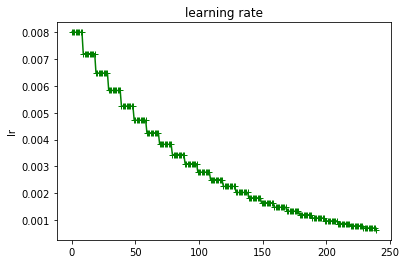

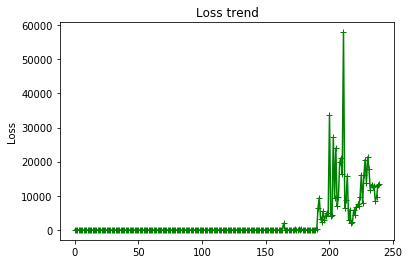

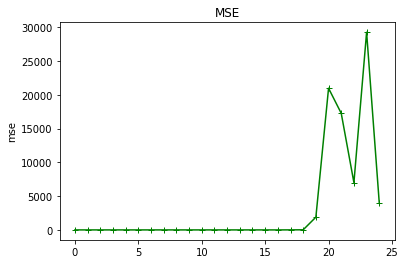

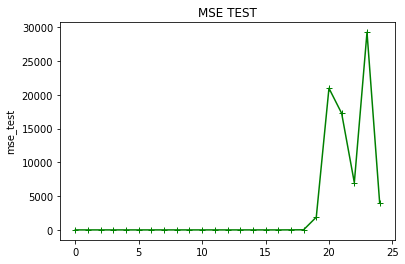

W0905 23:35:07.543934 140044405847872 deprecation.py:323] From <ipython-input-8-4f189e225c1a>:133: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
W0905 23:35:08.135195 140044405847872 deprecation.py:323] From /home/work/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


('test mse value ', 1.3548021)


In [8]:
#———————————————————对模型进行训练—————————————————————
do_matplot = True
do_save_model = True
model_saved_dir = "./model_save"
rm_status = os.system('rm -rf '+ model_saved_dir + '/*')

last_improved = 0
def train_rnn():
    global batch_size,last_improved
#     tf.reset_default_graph()
    with tf.variable_scope("sec_lstm"):
        pred=network("LSTM")
    batch_per_epoch = int(np.ceil(len(train_x)*1./batch_size))
    #指数型学习率参数
    global_step_train = tf.Variable(0, trainable=False) #调用minimize时会通过参数传递自动更新
    learning_rate_step = 10*batch_per_epoch #每10轮更新一次梯度
    learning_rate_decay = 0.9  #指数更新系数
    learning_rate = tf.train.exponential_decay(original_learning_rate, global_step_train, \
                                                        learning_rate_step, learning_rate_decay, staircase=True) #staircase=True表示每decay_steps计算学习速率变化
    #定义损失函数
    loss = tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)  #使用batch normalize
    with tf.control_dependencies(update_ops):
        train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step_train)
    #mse
    mse = tf.losses.mean_squared_error(pred, Y)
    

#     saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        lr_list = [] #收集学习率
        loss_list = [] #收集损失值
        mse_list = [] #收集mse
        test_loss_list = [] #test loss
        test_mse_list = [] #test mse
        #do early termination
        best_test_mse = 1e8
        max_improve_wait_step = 100
        hit_early_termination = False
        
        for i in range(train_epoch): #模型训练的次数，We can increase the number of iterations to gain better result.
            #shuffle the train_data
            batch_indexes = np.array_split(np.random.permutation(len(train_x)), batch_per_epoch)
            loop_loss = []
#             test_loop_loss = []
            for batch_index in batch_indexes:
                _,loss_=sess.run([train_op,loss],feed_dict = {X:train_x[batch_index], \
                                                              Y:np.reshape(train_y[batch_index], (-1, 1)), \
                                                              input_keep_prob:0.5, output_keep_prob:0.5, \
                                                              is_training:True})
                loop_loss.append(loss_)
#                 test_loss_=sess.run(loss,feed_dict = {X:test_x, \
#                                                               Y:np.reshape(test_y, (-1, 1)), \
#                                                               input_keep_prob:1., output_keep_prob:1., \
#                                                               is_training:False})
#                 test_loop_loss.append(test_loss_)
            
            if i % 10 == 0:
                mse_ = sess.run(mse, feed_dict = {X:train_x, \
                                                  Y:np.reshape(train_y, (-1, 1)), \
                                                  input_keep_prob:1., output_keep_prob:1., \
                                                  is_training:False})
                mse_list.append(mse_)
                test_mse_ = sess.run(mse, feed_dict = {X:test_x, \
                                                       Y:np.reshape(test_y, (-1, 1)), \
                                                       input_keep_prob:1., output_keep_prob:1.,\
                                                       is_training:False})
                test_mse_list.append(test_mse_)
                print("Number of iterations:",i," mse:", mse_, "test_mse_", test_mse_) #输出训练次数，输出mse
                
                if test_mse_ < best_test_mse:
                    best_test_mse = test_mse_
                    last_improved = i
                    
                    #model save
                    if do_save_model:
                        export_path = os.path.join(tf.compat.as_bytes(model_saved_dir), tf.compat.as_bytes(str(i)))
                        builder = tf.saved_model.builder.SavedModelBuilder(export_path)
                        tensor_info_input_keep_prob = tf.saved_model.utils.build_tensor_info(input_keep_prob)
                        tensor_info_output_keep_prob = tf.saved_model.utils.build_tensor_info(output_keep_prob)
                        tensor_info_training_flag = tf.saved_model.utils.build_tensor_info(is_training)
                        tensor_info_x = tf.saved_model.utils.build_tensor_info(X)
                        tensor_info_y = tf.saved_model.utils.build_tensor_info(pred)
                        prediction_signature = (
                            tf.saved_model.signature_def_utils.build_signature_def(
                                inputs={'fea': tensor_info_x, 
                                        'input_keep_prob':tensor_info_input_keep_prob, 
                                        'output_keep_prob':tensor_info_output_keep_prob, 
                                        'is_training':tensor_info_training_flag},
                                outputs={'pred': tensor_info_y},
                                method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))
                        builder.add_meta_graph_and_variables(
                            sess, [tf.saved_model.tag_constants.SERVING],
                            signature_def_map={
                                'predict_data': prediction_signature})
                        builder.save()
#                     print("model_save",saver.save(sess,'model_save/modle.ckpt')) #第二个参数是保存的地址，可以修改为自己本地的保存地址
                
                if i - last_improved > max_improve_wait_step:
                    hit_early_termination = True
                    break
                    
            loss_list.append(np.mean(loop_loss))
#             test_loss_list.append(np.mean(test_loop_loss))
            lr_list.append(sess.run(learning_rate))
            
            print("Number of iterations:",i," loss:", np.mean(loop_loss)) #输出训练次数，输出损失值
            
            if hit_early_termination:
                break
                
        print("The train has finished, train epoch = ", i, ",hit_early_termination=", hit_early_termination, "best_test_mse=", best_test_mse)
        
        if do_matplot:
            plt.plot(np.arange(0,len(lr_list)),lr_list,'+-',color = 'g')
            plt.title('learning rate')
            plt.ylabel('lr')
            plt.show()
#             loss_list = [v for v in loss_list if v<5]
            plt.plot(np.arange(0,len(loss_list)),loss_list,'+-',color = 'g')
            plt.title('Loss trend')
            plt.ylabel('Loss')
            plt.show()
# #             loss_list = [v for v in test_loss_list if v<5]
#             plt.plot(np.arange(0,len(test_loss_list)),test_loss_list,'+-',color = 'g')
#             plt.title('Loss trend test')
#             plt.ylabel('test_loss')
#             plt.show()
            plt.plot(np.arange(0,len(mse_list)),mse_list,'+-',color = 'g')
            plt.title('MSE')
            plt.ylabel('mse')
            plt.show()
            plt.plot(np.arange(0,len(mse_list)),mse_list,'+-',color = 'g')
            plt.title('MSE TEST')
            plt.ylabel('mse_test')
            plt.show()

        
        #使用最好的模型在测试集上预测mse
        if do_save_model:
            import_path = os.path.join(tf.compat.as_bytes(model_saved_dir), tf.compat.as_bytes(str(last_improved)))
            meta_graph_def = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], import_path)
            # 从meta_graph_def中取出SignatureDef对象
            signature = meta_graph_def.signature_def
            signature_key = "predict_data"
            fea_key = sess.graph.get_tensor_by_name(signature[signature_key].inputs["fea"].name)
            input_keep_prob_key = sess.graph.get_tensor_by_name(signature[signature_key].inputs["input_keep_prob"].name)
            output_keep_prob_key = sess.graph.get_tensor_by_name(signature[signature_key].inputs["output_keep_prob"].name)
            training_flag_key = sess.graph.get_tensor_by_name(signature[signature_key].inputs["is_training"].name)
            pred_key = sess.graph.get_tensor_by_name(signature[signature_key].outputs["pred"].name)
            pred_res = sess.run(pred_key, feed_dict={fea_key:test_x, \
                                                     input_keep_prob_key:1., output_keep_prob_key:1., \
                                                     training_flag_key:False})
            
            test_mse = sess.run(tf.losses.mean_squared_error(pred_res, np.reshape(test_y, (-1, 1))))
        else:
            test_mse = sess.run(mse, feed_dict = {X:test_x, \
                                        Y:np.reshape(test_y, (-1, 1)), \
                                        input_keep_prob:1., output_keep_prob:1., \
                                        is_training: False})
        print("test mse value ", test_mse)
        
train_rnn() #对模型进行训练

In [9]:
# #learning rate = 0.0005, learning_rate_decay=0.9
# ('Number of iterations:', 0, ' mse:', 277.3063, 'test_mse_', 300.56897)
# ('Number of iterations:', 0, ' loss:', 12636.504)
# ('Number of iterations:', 1, ' loss:', 3090.8582)
# ('Number of iterations:', 2, ' loss:', 139.15874)
# ('Number of iterations:', 3, ' loss:', 64.151405)
# ('Number of iterations:', 4, ' loss:', 358.9761)
# ('Number of iterations:', 5, ' loss:', 24.930973)
# ('Number of iterations:', 6, ' loss:', 9.706715)
# ('Number of iterations:', 7, ' loss:', 3.7594965)
# ('Number of iterations:', 8, ' loss:', 2.9373744)
# ('Number of iterations:', 9, ' loss:', 2.5696945)
# ('Number of iterations:', 10, ' mse:', 2.3313763, 'test_mse_', 2.6493483)
# ('Number of iterations:', 10, ' loss:', 2.40858)
# ('Number of iterations:', 11, ' loss:', 2.279276)
# ('Number of iterations:', 12, ' loss:', 2.1252275)
# ('Number of iterations:', 13, ' loss:', 1.9203985)
# ('Number of iterations:', 14, ' loss:', 1.8085206)
# ('Number of iterations:', 15, ' loss:', 1.6113774)
# ('Number of iterations:', 16, ' loss:', 1.5209328)
# ('Number of iterations:', 17, ' loss:', 1.5583917)
# ('Number of iterations:', 18, ' loss:', 1.4670149)
# ('Number of iterations:', 19, ' loss:', 1.4575567)
# ('Number of iterations:', 20, ' mse:', 1.3990803, 'test_mse_', 1.5741584)
# ('Number of iterations:', 20, ' loss:', 1.4843664)
# ('Number of iterations:', 21, ' loss:', 1.4182106)
# ('Number of iterations:', 22, ' loss:', 1.3836938)
# ('Number of iterations:', 23, ' loss:', 1.4110873)
# ('Number of iterations:', 24, ' loss:', 1.3238561)
# ('Number of iterations:', 25, ' loss:', 1.2520941)
# ('Number of iterations:', 26, ' loss:', 1.329352)
# ('Number of iterations:', 27, ' loss:', 1.1980892)
# ('Number of iterations:', 28, ' loss:', 1.0536932)
# ('Number of iterations:', 29, ' loss:', 1.0277358)
# ('Number of iterations:', 30, ' mse:', 0.9392812, 'test_mse_', 1.0586816)
# ('Number of iterations:', 30, ' loss:', 0.97684735)
# ('Number of iterations:', 31, ' loss:', 0.94775194)
# ('Number of iterations:', 32, ' loss:', 0.98330265)
# ('Number of iterations:', 33, ' loss:', 0.90434134)
# ('Number of iterations:', 34, ' loss:', 0.8707473)
# ('Number of iterations:', 35, ' loss:', 0.8518898)
# ('Number of iterations:', 36, ' loss:', 0.85643715)
# ('Number of iterations:', 37, ' loss:', 0.84937006)
# ('Number of iterations:', 38, ' loss:', 0.8266152)
# ('Number of iterations:', 39, ' loss:', 0.8171346)
# ('Number of iterations:', 40, ' mse:', 0.76445526, 'test_mse_', 0.8698976)
# ('Number of iterations:', 40, ' loss:', 0.8224517)
# ('Number of iterations:', 41, ' loss:', 0.81172)
# ('Number of iterations:', 42, ' loss:', 0.7809564)
# ('Number of iterations:', 43, ' loss:', 0.7888052)
# ('Number of iterations:', 44, ' loss:', 0.79022497)
# ('Number of iterations:', 45, ' loss:', 0.77060205)
# ('Number of iterations:', 46, ' loss:', 0.76950175)
# ('Number of iterations:', 47, ' loss:', 0.7849097)
# ('Number of iterations:', 48, ' loss:', 0.7809587)
# ('Number of iterations:', 49, ' loss:', 0.7676193)
# ('Number of iterations:', 50, ' mse:', 0.7403139, 'test_mse_', 0.8734424)
# ('Number of iterations:', 50, ' loss:', 0.7549475)
# ('Number of iterations:', 51, ' loss:', 0.7517656)
# ('Number of iterations:', 52, ' loss:', 0.7538919)
# ('Number of iterations:', 53, ' loss:', 0.75118667)
# ('Number of iterations:', 54, ' loss:', 0.7550804)
# ('Number of iterations:', 55, ' loss:', 0.7433465)
# ('Number of iterations:', 56, ' loss:', 0.7510279)
# ('Number of iterations:', 57, ' loss:', 0.75038195)
# ('Number of iterations:', 58, ' loss:', 0.7408243)
# ('Number of iterations:', 59, ' loss:', 0.7342166)
# ('Number of iterations:', 60, ' mse:', 0.7082391, 'test_mse_', 0.80120635)
# ('Number of iterations:', 60, ' loss:', 0.73564357)
# ('Number of iterations:', 61, ' loss:', 0.73085237)
# ('Number of iterations:', 62, ' loss:', 0.73153675)
# ('Number of iterations:', 63, ' loss:', 0.7363246)
# ('Number of iterations:', 64, ' loss:', 0.7304109)
# ('Number of iterations:', 65, ' loss:', 0.7258571)
# ('Number of iterations:', 66, ' loss:', 0.7223647)
# ('Number of iterations:', 67, ' loss:', 0.7173189)
# ('Number of iterations:', 68, ' loss:', 0.720853)
# ('Number of iterations:', 69, ' loss:', 0.72392577)
# ('Number of iterations:', 70, ' mse:', 0.72717744, 'test_mse_', 0.78538805)
# ('Number of iterations:', 70, ' loss:', 0.71902335)
# ('Number of iterations:', 71, ' loss:', 0.7130223)
# ('Number of iterations:', 72, ' loss:', 0.71265113)
# ('Number of iterations:', 73, ' loss:', 0.7117342)
# ('Number of iterations:', 74, ' loss:', 0.71052945)
# ('Number of iterations:', 75, ' loss:', 0.7063599)
# ('Number of iterations:', 76, ' loss:', 0.70881504)
# ('Number of iterations:', 77, ' loss:', 0.7062867)
# ('Number of iterations:', 78, ' loss:', 0.7141351)
# ('Number of iterations:', 79, ' loss:', 0.7118051)
# ('Number of iterations:', 80, ' mse:', 0.6848366, 'test_mse_', 0.7991062)
# ('Number of iterations:', 80, ' loss:', 0.70438004)
# ('Number of iterations:', 81, ' loss:', 0.70149636)
# ('Number of iterations:', 82, ' loss:', 0.7020492)
# ('Number of iterations:', 83, ' loss:', 0.7036402)
# ('Number of iterations:', 84, ' loss:', 0.70198625)
# ('Number of iterations:', 85, ' loss:', 0.69468087)
# ('Number of iterations:', 86, ' loss:', 0.6996585)
# ('Number of iterations:', 87, ' loss:', 0.6944026)
# ('Number of iterations:', 88, ' loss:', 0.68889683)
# ('Number of iterations:', 89, ' loss:', 0.6899125)
# ('Number of iterations:', 90, ' mse:', 0.690834, 'test_mse_', 0.81951153)
# ('Number of iterations:', 90, ' loss:', 0.69712675)
# ('Number of iterations:', 91, ' loss:', 0.68989813)
# ('Number of iterations:', 92, ' loss:', 0.6878052)
# ('Number of iterations:', 93, ' loss:', 0.68881375)
# ('Number of iterations:', 94, ' loss:', 0.6920298)
# ('Number of iterations:', 95, ' loss:', 0.68462986)
# ('Number of iterations:', 96, ' loss:', 0.6833937)
# ('Number of iterations:', 97, ' loss:', 0.6880767)
# ('Number of iterations:', 98, ' loss:', 0.68908626)
# ('Number of iterations:', 99, ' loss:', 0.6839101)
# ('The train has finished, train epoch = ', 99, ',hit_early_termination=', False, 'best_test_mse=', 0.78538805)
# /home/work/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
#   (prop.get_family(), self.defaultFamily[fontext]))



# W0830 21:57:16.550570 140635288450880 deprecation.py:323] From <ipython-input-7-91c949df90cd>:109: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
# Instructions for updating:
# This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
# W0830 21:57:16.831374 140635288450880 deprecation.py:323] From /home/work/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
# Instructions for updating:
# Use standard file APIs to check for files with this prefix.
# ('test mse value ', 0.78538805)

           biz_id car_type   time_section  cnt  car_type-0  car_type-1  \
0  need_city2_101        0  2019-09-01 00  0.0         1.0         0.0   
1  need_city2_111        0  2019-09-01 00  0.0         1.0         0.0   
2  need_city2_111        1  2019-09-01 00  0.0         0.0         1.0   
3  need_city2_118        0  2019-09-01 00  0.0         1.0         0.0   
4  need_city2_123        0  2019-09-01 00  0.0         1.0         0.0   

   car_type-10  car_type-11  car_type-12  car_type-2        ...         \
0          0.0          0.0          0.0         0.0        ...          
1          0.0          0.0          0.0         0.0        ...          
2          0.0          0.0          0.0         0.0        ...          
3          0.0          0.0          0.0         0.0        ...          
4          0.0          0.0          0.0         0.0        ...          

   temperature-24.0  temperature-25.0  temperature-26.0  temperature-27.0  \
0               0.0              

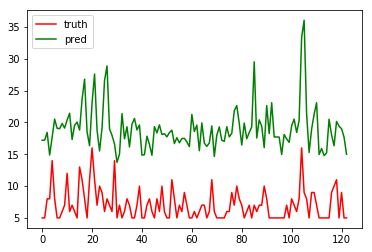

In [10]:
######上海效果
#———————————————————数据抽取—————————————————————
columns = ['biz_id', 'car_type', 'section', 'week_id', 'holiday_id', 'temperature', 'weather', 'target']
from hive_client import HiveClient
hive_client = HiveClient()
begin_date = '2019-09-01'
begin_date_unformatted = '20190901'
end_date = '2019-09-05'
end_date_unformatted = '20190905'

load_pickle = True
#天气
hsql='''
    select distinct city_id,temperature,weather_desc,report_time,
    from_unixtime(unix_timestamp(report_time,'yyyy-MM-dd HH:mm:ss')+1800,'yyyy-MM-dd HH:mm:ss') as report_end_time
    from daojia_ml.express_weather_info
    where report_time>='{0}' and report_time<'{1}'
'''.format(begin_date, end_date)
if(load_pickle == False):
    with open('data/weather_test', 'w+') as f:
        status, weather_res = hive_client.query(hsql)
        pickle.dump(weather_res, f)
else:
    with open('data/weather_test', 'r') as f:
        weather_res = pickle.load(f)
weather_df = pd.DataFrame(weather_res, columns=['city_id', 'temperature', 'weather', 'start', 'end'])

#日期
hsql='''
    select distinct to_date(service_time) as service_dt,
    service_time_week_id, service_time_holiday_id
    from daojia_ml.express_odp_order_info_test
    where dt>='{0}' and dt<'{1}'
'''.format(begin_date_unformatted, end_date_unformatted)
if(load_pickle == False):
    with open('data/date_test', 'w+') as f:
        status, date_res = hive_client.query(hsql)
        pickle.dump(date_res, f)
else:
    with open('data/date_test', 'r') as f:
        date_res = pickle.load(f)
date_df = pd.DataFrame(date_res, columns=['service_dt', 'week_id', 'holiday_id'])


#商圈
headers='''
ADD jar hdfs://nameservice1/bigdata_platform/hive_udf/business-all.jar;
CREATE temporary FUNCTION get_biz AS 'com.daojia.business.district.view.commons.validate.BusinessByGps';
'''
hsql='''
    select city_id,car_type,service_time,
    split(get_biz(start_gps,cast(city_id as int)),',')[2] as biz_id
    from sy_dw_f.f_agt_order_info
    where service_time>='{0}' and service_time<'{1}'
    and split(get_biz(start_gps,cast(city_id as int)),',')[2]!=''
    and need_last_order='Y' and state=7 and city_id=2
'''.format(begin_date, end_date)
if(load_pickle == False):
    with open('data/biz_test', 'w+') as f:
        status, biz_res = hive_client.query(hsql, headers=headers)
        pickle.dump(biz_res, f)
else:
    with open('data/biz_test', 'r') as f:
        biz_res = pickle.load(f)
biz_df = pd.DataFrame(biz_res, columns=['city_id', 'car_type', 'service_time', 'biz_id'])

biz_df = biz_df[(biz_df.biz_id != '') & (biz_df.biz_id!='NULL')]
time_section = []
time_groupkey = []
for index,row in biz_df.iterrows():
    t_time = row['service_time'].split(':')[0]
    time_section.append(t_time)
    time_groupkey.append(row['biz_id']+','+row['car_type']+','+t_time)
biz_df['time_section'] = time_section
biz_df['time_groupkey'] = time_groupkey
time_count = biz_df.groupby(['time_groupkey'])['service_time'].size()


# 每小时一个分段
cur_time = datetime.datetime.strptime(biz_df['service_time'].min(), '%Y-%m-%d %H:%M:%S')
end_time = datetime.datetime.strptime(biz_df['service_time'].max(), '%Y-%m-%d %H:%M:%S')
index_uniq = biz_df.groupby(['city_id','biz_id','car_type'])['time_section'].apply(lambda x:len(x.unique()))
index_uniq = [idx for idx in index_uniq.index if index_uniq[idx]>=10]
vals = []
weather_info = {}
while cur_time < end_time:
    hour = cur_time.hour
    cur_time_date = cur_time.strftime('%Y-%m-%d')
    cur_time_str = cur_time.strftime('%Y-%m-%d %H')
    t_date = date_df[date_df.service_dt==cur_time_date]
    t_week = t_date['week_id'].values[0] if len(t_date) > 0 else np.nan
    t_holiday = t_date['holiday_id'].values[0] if len(t_date) > 0 else np.nan
    for idx in index_uniq:
        if cur_time_str not in weather_info:
            t_weather = weather_df[(weather_df.city_id==idx[0]) & (weather_df.end>cur_time_str)].sort_values(by=['start'])
            t_temperature = t_weather['temperature'].values[0] if len(t_weather)>0 else np.nan
            t_weather_val = t_weather['weather'].values[0] if len(t_weather)>0 else np.nan
            weather_info[cur_time_str] = (t_temperature, t_weather_val)
        t_temperature = weather_info[cur_time_str][0]
        t_weather_val = weather_info[cur_time_str][1]
        t_biz_key = idx[1] + ',' + idx[2] + ',' + cur_time_str
        t_cnt = time_count[t_biz_key] if t_biz_key in time_count.index else 0
        vals.append([idx[1], idx[2], cur_time_str, idx[0], t_week, t_holiday, hour, t_temperature, t_weather_val, t_cnt])
    cur_time+=datetime.timedelta(hours=1)

data = pd.DataFrame(vals, columns=['biz_id','car_type','time_section','city_id','week_id','holiday_id','hour','temperature','weather','cnt']).astype('float32', errors='ignore')
# print len(data)
# print data.head()

#———————————————————特征处理—————————————————————
do_embedding = False
do_embedding_update = False
item_vector_path = 'embedding_model/item_vector'
feature_dict_path = 'embedding_model/feature_dict'
item_vector_dimension = 30

if do_embedding:
    #index
    item_dict = {}
    item_cnt = 0
    item_col = []
    for idx,row in data.iterrows():
        key = str(row['car_type']) + ',' + str(row['city_id']) + ',' + str(row['week_id']) \
            + ',' + str(row['holiday_id']) + ',' + str(row['hour']) + ',' + str(row['weather']) + ',' + str(row['temperature'])
        if key not in item_dict:
            item_dict[key] = item_cnt
            item_cnt += 1
        item_col.append(str(item_dict[key]))
    item_df = data.loc[:, ['biz_id', 'car_type', 'time_section']]
    item_df['item'] = item_col
    
    #generate sentence
    item_list = []
    item_groupby = item_df.groupby(['biz_id','car_type'])
    for name,group in item_groupby:
        t_data = group.sort_values(by=['time_section']).drop(['biz_id','car_type','time_section'], axis=1)
        item_list.append(list(t_data['item'].values))
    
    #embedding
    from itertools import imap
    item_vector = {}
    with open(item_vector_path, 'r') as f:
        for line in f.readlines():
            item,vec_str = line.split('\t')
            weight_vec = [float(w) for w in vec_str.split(',')]
            item_vector[item] = weight_vec
            
    #vector joint
    item_vec_cols = [[] for i in range(item_vector_dimension)]
    for idx,row in data.iterrows():
        key = str(row['car_type']) + ',' + str(row['city_id']) + ',' + str(row['week_id']) \
            + ',' + str(row['holiday_id']) + ',' + str(row['hour']) + ',' + str(row['weather']) + ',' + str(row['temperature'])
        item_vec = np.zeros(item_vector_dimension)
        if key in item_vector:
            item_vec = item_vector[key]
        for i,t in enumerate(item_vec_cols):
            t.append(item_vec[i])
    for i in range(item_vector_dimension):
        data['embedding_'+str(i)] = item_vec_cols[i]
    data = data.drop(['city_id','week_id','holiday_id','hour','weather','temperature'], axis=1)
else:
    feature_dict = {}
    feature_list = []
    with open(feature_dict_path, 'r') as f:
        for line in f.readlines():
            l = line.split('\t')
            feature_dict[l[0]] = int(l[1])
            feature_list.append(l[0])
    onehot_cols = np.zeros([len(feature_dict),len(data)])
    for idx,row in data.iterrows():
        key = 'car_type-'+str(row['car_type'])
        if key not in feature_dict: continue
        val = feature_dict[key]
        onehot_cols[val][idx] = 1
    for fea in feature_list:
        data[fea] = onehot_cols[feature_dict[fea]]
    data = data.drop(['city_id','week_id','holiday_id','hour','weather','temperature'], axis=1)
print data.head()

#———————————————————形成训练集—————————————————————
data_groupby = data.groupby(['biz_id','car_type'])
data_x = []
data_y = []
data_cnt = 0
for name,group in data_groupby:
    t_data = group.sort_values(by=['time_section']).drop(['biz_id','car_type','time_section'], axis=1)
#     X = t_data.drop(['cnt'], axis=1)
    X = t_data
    Y = t_data['cnt']
    for i in range(time_step, len(X)):
        data_x.append(X.iloc[i-time_step:i].astype('float32').values.tolist())
        data_y.append(Y.iloc[i])
data_x = np.array(data_x)
data_y = np.array(data_y)
print len(data_x), len(data_y)


#———————————————————样本预测—————————————————————
with tf.Session() as sess:
    import_path = os.path.join(tf.compat.as_bytes(model_saved_dir), tf.compat.as_bytes(str(last_improved)))
    meta_graph_def = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], import_path)
    # 从meta_graph_def中取出SignatureDef对象
    signature = meta_graph_def.signature_def
    signature_key = "predict_data"
    fea_key = sess.graph.get_tensor_by_name(signature[signature_key].inputs["fea"].name)
    input_keep_prob_key = sess.graph.get_tensor_by_name(signature[signature_key].inputs["input_keep_prob"].name)
    output_keep_prob_key = sess.graph.get_tensor_by_name(signature[signature_key].inputs["output_keep_prob"].name)
    training_flag_key = sess.graph.get_tensor_by_name(signature[signature_key].inputs["is_training"].name)
    pred_key = sess.graph.get_tensor_by_name(signature[signature_key].outputs["pred"].name)
    pred_res = sess.run(pred_key, feed_dict={fea_key:data_x, \
                                             input_keep_prob_key:1., output_keep_prob_key:1., \
                                             training_flag_key:False})

    plot_y = [i for i,y in enumerate(data_y) if y>=5]
    print len(plot_y)
    plt.plot(range(len(plot_y)), data_y[plot_y],label=u'truth',color='red')
    plt.plot(range(len(plot_y)), pred_res[plot_y],label=u'pred',color='green')
    plt.legend()
    plt.show()